In [3]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import numpy as np
import folium
import requests

In [4]:
# load the census shape and tract
census_shape = gpd.read_file("shape/lda_000a21a_e/lda_000a21a_e.shp")
census_tract = pd.read_csv("csv/census_ontario_selected_columns.csv")

# Store the ontario stats separately
ontario_stats = census_tract[1:2].copy(deep=True)

# Filter for Ontario only
census_shape = census_shape[census_shape["PRUID"] == "35"]

# drop PRUID and DGUID as unncessary and convert object to int column
census_shape.drop(columns=["PRUID", "DGUID"], inplace=True)
census_shape["DAUID"] = census_shape["DAUID"].values.astype(int)

# merge the columns together
census_df = pd.merge(
    census_tract, census_shape, left_on="ALT_GEO_CODE", right_on="DAUID", how="inner"
)

# Convert to geodataframe
census_gdf = gpd.GeoDataFrame(census_df, geometry="geometry")

# Convert to WGS84 projection
census_gdf.to_crs("WGS84", inplace=True)

# load the pharmacy data
pharmacy_df = pd.read_csv("csv/Fixed OCP Search.csv")

# Get only active pharmacy
pharmacy_df = pharmacy_df[pharmacy_df["Status"] == "Active"]

# Convert to geodataframe
pharmacy_gpf = gpd.GeoDataFrame(
    pharmacy_df,
    geometry=gpd.points_from_xy(pharmacy_df["Longitude"], pharmacy_df["Latitude"]),
)

# pharmacy_gpf = gpd.read_file("./geojson/pharmacy.geojson")

# Set reference to standard WGS84
pharmacy_gpf.set_crs("wgs84", allow_override=True, inplace=True)

# load the doctor data
doctor_pf = pd.read_csv("csv/doctors.csv")

# get only the unique clinics that are near here
doctor_pf = doctor_pf.groupby("Postal Code").first()

# Convert to geodataframe
doctor_gpf = gpd.GeoDataFrame(
    doctor_pf,
    geometry=gpd.points_from_xy(doctor_pf["Longitude"], doctor_pf["Latitude"]),
)

# doctor_gpf = gpd.read_file("./geojson/doctors.geojson")
# Set reference to standard WGS84
doctor_gpf.set_crs("wgs84", allow_override=True, inplace=True)

dentist_gpf = gpd.read_file("./geojson/dentist.geojson")
# Set reference to standard WGS84
dentist_gpf.set_crs("wgs84", allow_override=True, inplace=True)


# FIlter for locations within the bounding box
doctor_gpf = doctor_gpf[(doctor_gpf.centroid.x > -85) & (doctor_gpf.centroid.x < -77)]
doctor_gpf = doctor_gpf[(doctor_gpf.centroid.y < 45.6) & (doctor_gpf.centroid.y > 40)]

phamracy_gpf = pharmacy_gpf[
    (pharmacy_gpf.centroid.x > -85) & (pharmacy_gpf.centroid.x < -77)
]
pharmacy_gpf = pharmacy_gpf[
    (pharmacy_gpf.centroid.y < 45.6) & (pharmacy_gpf.centroid.y > 40)
]

dentist_gpf = dentist_gpf[
    (dentist_gpf.centroid.x > -85) & (dentist_gpf.centroid.x < -77)
]

deintist_gpf = dentist_gpf[
    (dentist_gpf.centroid.y < 45.6) & (dentist_gpf.centroid.y > 40)
]

census_gdf = census_gdf[(census_gdf.centroid.y < 45.6) & (census_gdf.centroid.y > 40)]


sum_col = [
    "Population, 2021",
    "Population, 2016",
    "Total private dwellings",
    "  65 years and over",
    "  Owner",
    "    Bachelor's degree or higher",
    "Population, 2026",
    "0 to 24 years",
    "25 to 64 years",
]

mean_col = [
    "Average household size",
    "Population percentage change, 2016 to 2021",
    "Population density per square kilometre",
    "    Median after-tax income in 2020 among recipients ($)",
    "  Median after-tax income of household in 2020 ($)",
    "Median age of the population",
    "White Collar Percentage",
]


C:\Users\shann\AppData\Local\Temp\ipykernel_9076\4068011764.py:65: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  doctor_gpf = doctor_gpf[(doctor_gpf.centroid.x > -85) & (doctor_gpf.centroid.x < -77)]
C:\Users\shann\AppData\Local\Temp\ipykernel_9076\4068011764.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  doctor_gpf = doctor_gpf[(doctor_gpf.centroid.y < 45.6) & (doctor_gpf.centroid.y > 40)]
C:\Users\shann\AppData\Local\Temp\ipykernel_9076\4068011764.py:69: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (pharmacy_gpf.centroid.x > -85) & (pharmacy_gpf.centroid.x < -77

In [5]:
# Helper function to get buffer size around point of interest (POI)
def get_buffer(radius=2000, point=None, buffer_type="radius"):
    # if using the simple radius method
    if buffer_type == "radius":
        gdf = gpd.GeoDataFrame({"geometry": point}, index=[0])
        # Set the CRS to wgs84 then to EPSG:3347 to create a buffer of 2 km radius
        gdf.set_crs("wgs84", allow_override=True, inplace=True)
        gdf.to_crs("EPSG:3347", inplace=True)

        # Create a buffer of 2 km
        gdf["geometry"] = gdf.buffer(radius)

        # convert back to wgs84
        gdf.to_crs("wgs84", inplace=True)
        return gdf
    
    # using the more complex isochrone method
    # didnt use it because it tends to overestimate without traffic accounted for
    else:
        response = requests.post(
            "http://localhost:8080/ors/v2/isochrones/driving-car",
            json={
                "locations": [[point.x, point.y]],
                "range": [900],  # 15 mins
                "range_type": "time",
            },
        )

        # Convert the isocrhone into a polygon
        poly = Polygon(response.json()["features"][0]["geometry"]["coordinates"][0])

        # convert to geodataframe
        gdf = gpd.GeoDataFrame({"geometry": poly}, index=[0])
        gdf.set_crs("wgs84", allow_override=True, inplace=True)
    
        return gdf


def show_southern_ontario_map(
    census_gdf=None, doctor_gpf=None, pharmacy_gpf=None, dentist_gpf=None, point_gdf=None
):
    _, ax = plt.subplots(figsize=(16, 24))

    census_gdf.plot(ax=ax, color="blue")
    doctor_gpf.plot(ax=ax, color="red")
    pharmacy_gpf.plot(ax=ax, color="green")
    dentist_gpf.plot(ax=ax, color="purple")
    point_gdf.plot(ax=ax, color="yellow")

    plt.show()


def show_map(
    census_within_buffer=None,
    doctor_within_buffer=None,
    buffer_gdf=None,
    pharmacy_within_buffer=None,
    dentist_within_buffer=None,
):
    _, ax = plt.subplots(figsize=(16, 16))

    buffer_gdf.plot(ax=ax, color="gray")
    try:
        census_within_buffer.plot(ax=ax, color="blue")
    except:
        pass

    try:
        doctor_within_buffer.plot(ax=ax, color="red")
    except:
        pass

    try:
        pharmacy_within_buffer.plot(ax=ax, color="green")
    except:
        pass
    
    try:
        dentist_within_buffer.plot(ax=ax, color="purple")
    except:
        pass

    plt.show()


def show_folium_map(
    census_within_buffer=None,
    doctor_within_buffer=None,
    buffer_gdf=None,
    pharmacy_within_buffer=None,
    dentist_within_buffer=None,
    point=None,
):
    m = census_within_buffer.explore(name="census")
    m = buffer_gdf.explore(m=m, color="gray", name="Buffer")
    m = pharmacy_within_buffer.explore(m=m, color="green", name="Pharmacy")
    m = doctor_within_buffer.explore(m=m, color="red", name="Doctors")
    m = dentist_within_buffer.explore(m=m, color="purple", name="Dentist")
    
    point_geo = gpd.GeoDataFrame({"geometry": point}, index=[0])
    m = point_geo.explore(m=m, color="yellow", name="Point")
    
    return m


In [9]:
cumulative_stats = pd.DataFrame()

for iter, row in pharmacy_gpf.iterrows():
    point = row['geometry'] 
    buffer_gdf = get_buffer(point=point)

    predicate = 'intersects'

    census_within_buffer = gpd.sjoin(census_gdf, buffer_gdf, how='inner', predicate=predicate)
    pharmacy_within_buffer = gpd.sjoin(pharmacy_gpf, buffer_gdf, how='inner', predicate=predicate)
    doctor_within_buffer = gpd.sjoin(doctor_gpf, buffer_gdf, how='inner', predicate=predicate)
    dentist_within_buffer = gpd.sjoin(dentist_gpf, buffer_gdf, how='inner', predicate=predicate)
    
    num_of_docs = doctor_within_buffer['City'].count()
    num_of_pharmacies = pharmacy_within_buffer['City'].count()
    num_of_dentists = dentist_within_buffer['id'].count()
    # DF that tracks the status within buffer
    stats_within_radius = pd.DataFrame()

    for col in sum_col:
        stats_within_radius.loc[0, col] = int(census_within_buffer[col].sum())

    for col in mean_col:
        stats_within_radius.loc[0, col] = round(census_within_buffer[col].mean(), 1)


    stats_within_radius['num of pharmacies'] = num_of_pharmacies
    stats_within_radius['num of doctors'] = num_of_docs
    stats_within_radius['num of dentists'] = num_of_dentists
    stats_within_radius['geometry'] = point

    cumulative_stats = pd.concat([cumulative_stats, stats_within_radius], ignore_index=True)
    
quantitle_stats = cumulative_stats.quantile([0.25, 0.5, 0.75, 0.9])
quantitle_stats.to_csv("quantitle_stats.csv")

KeyboardInterrupt: 

In [10]:
cumulative_stats

,geometry,"Population, 2021","Population, 2016",Total private dwellings,65 years and over,Owner,Bachelor's degree or higher,"Population, 2026",0 to 24 years,25 to 64 years,Average household size,"Population percentage change, 2016 to 2021",Population density per square kilometre,Median after-tax income in 2020 among recipients ($),Median after-tax income of household in 2020 ($),Median age of the population,White Collar Percentage,num of pharmacies,num of doctors,num of dentists
0,NaN,47351.0,0.0,21590.0,330.0,10270.0,14805.0,0.0,8365.0,38655.0,2.4,NaN,4838.4,50389.9,103136.2,42.8,58.8,17,0,0
1,NaN,67921.0,0.0,21907.0,385.0,18440.0,17985.0,0.0,8852.0,58468.0,3.1,NaN,4037.0,38804.4,108084.4,44.9,46.7,21,16,3
2,NaN,159655.0,0.0,110168.0,1280.0,35500.0,81025.0,0.0,19220.0,138655.0,1.8,NaN,26350.7,43429.0,67180.0,37.0,59.7,69,128,44
3,NaN,24840.0,0.0,11565.0,95.0,6685.0,4095.0,0.0,3466.0,21278.0,2.3,NaN,2921.9,36131.7,70251.2,43.6,30.8,12,16,3
4,NaN,39273.0,0.0,15427.0,610.0,12145.0,12780.0,0.0,4657.0,33819.0,3.0,NaN,3906.3,35740.7,106388.9,48.6,48.9,13,20,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,NaN,14603.0,0.0,5703.0,15.0,4215.0,1560.0,0.0,1967.0,12620.0,2.7,NaN,1785.3,37838.1,88061.9,43.1,34.9,3,2,0
1514,NaN,43131.0,0.0,17910.0,555.0,13330.0,13850.0,0.0,5185.0,37204.0,2.8,NaN,3031.7,39292.6,103350.0,49.0,51.5,9,14,0
1515,NaN,40606.0,0.0,18695.0,230.0,9625.0,12715.0,0.0,6470.0,33905.0,2.4,NaN,3136.3,52545.6,106319.3,44.3,59.6,11,0,0
1516,NaN,513.0,0.0,243.0,5.0,185.0,20.0,0.0,70.0,437.0,2.4,NaN,5.0,30600.0,59600.0,53.6,15.2,1,1,0


In [7]:
gps = [43.46742835703337, -79.69045618438133]
point = Point(gps[1], gps[0])
buffer_gdf = get_buffer(point=point)

predicate = "intersects"

census_within_buffer = gpd.sjoin(census_gdf, buffer_gdf, how="inner", predicate=predicate)
pharmacy_within_buffer = gpd.sjoin(
    pharmacy_gpf, buffer_gdf, how="inner", predicate=predicate
)
doctor_within_buffer = gpd.sjoin(doctor_gpf, buffer_gdf, how="inner", predicate=predicate)
dentist_within_buffer= gpd.sjoin(
    dentist_gpf, buffer_gdf, how="inner", predicate=predicate
)
num_of_docs = doctor_within_buffer['City'].count()
num_of_pharmacies = pharmacy_within_buffer['City'].count()


summary_stats_within_radius = pd.DataFrame()

for col in sum_col:
    summary_stats_within_radius.loc[0, col] = int(census_within_buffer[col].sum())

for col in mean_col:
    summary_stats_within_radius.loc[0, col] = round(census_within_buffer[col].mean(), 1)


summary_stats_within_radius['num of pharmacies'] = num_of_pharmacies
summary_stats_within_radius['num of doctors'] = num_of_docs
summary_stats_within_radius['num of dentists'] = dentist_within_buffer['id'].count()
summary_stats_within_radius['geometry'] = point


show_folium_map(
    census_within_buffer=census_within_buffer,
    doctor_within_buffer=doctor_within_buffer,
    point=point,
    pharmacy_within_buffer=pharmacy_within_buffer,
    buffer_gdf=buffer_gdf,
    dentist_within_buffer=dentist_within_buffer,
)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

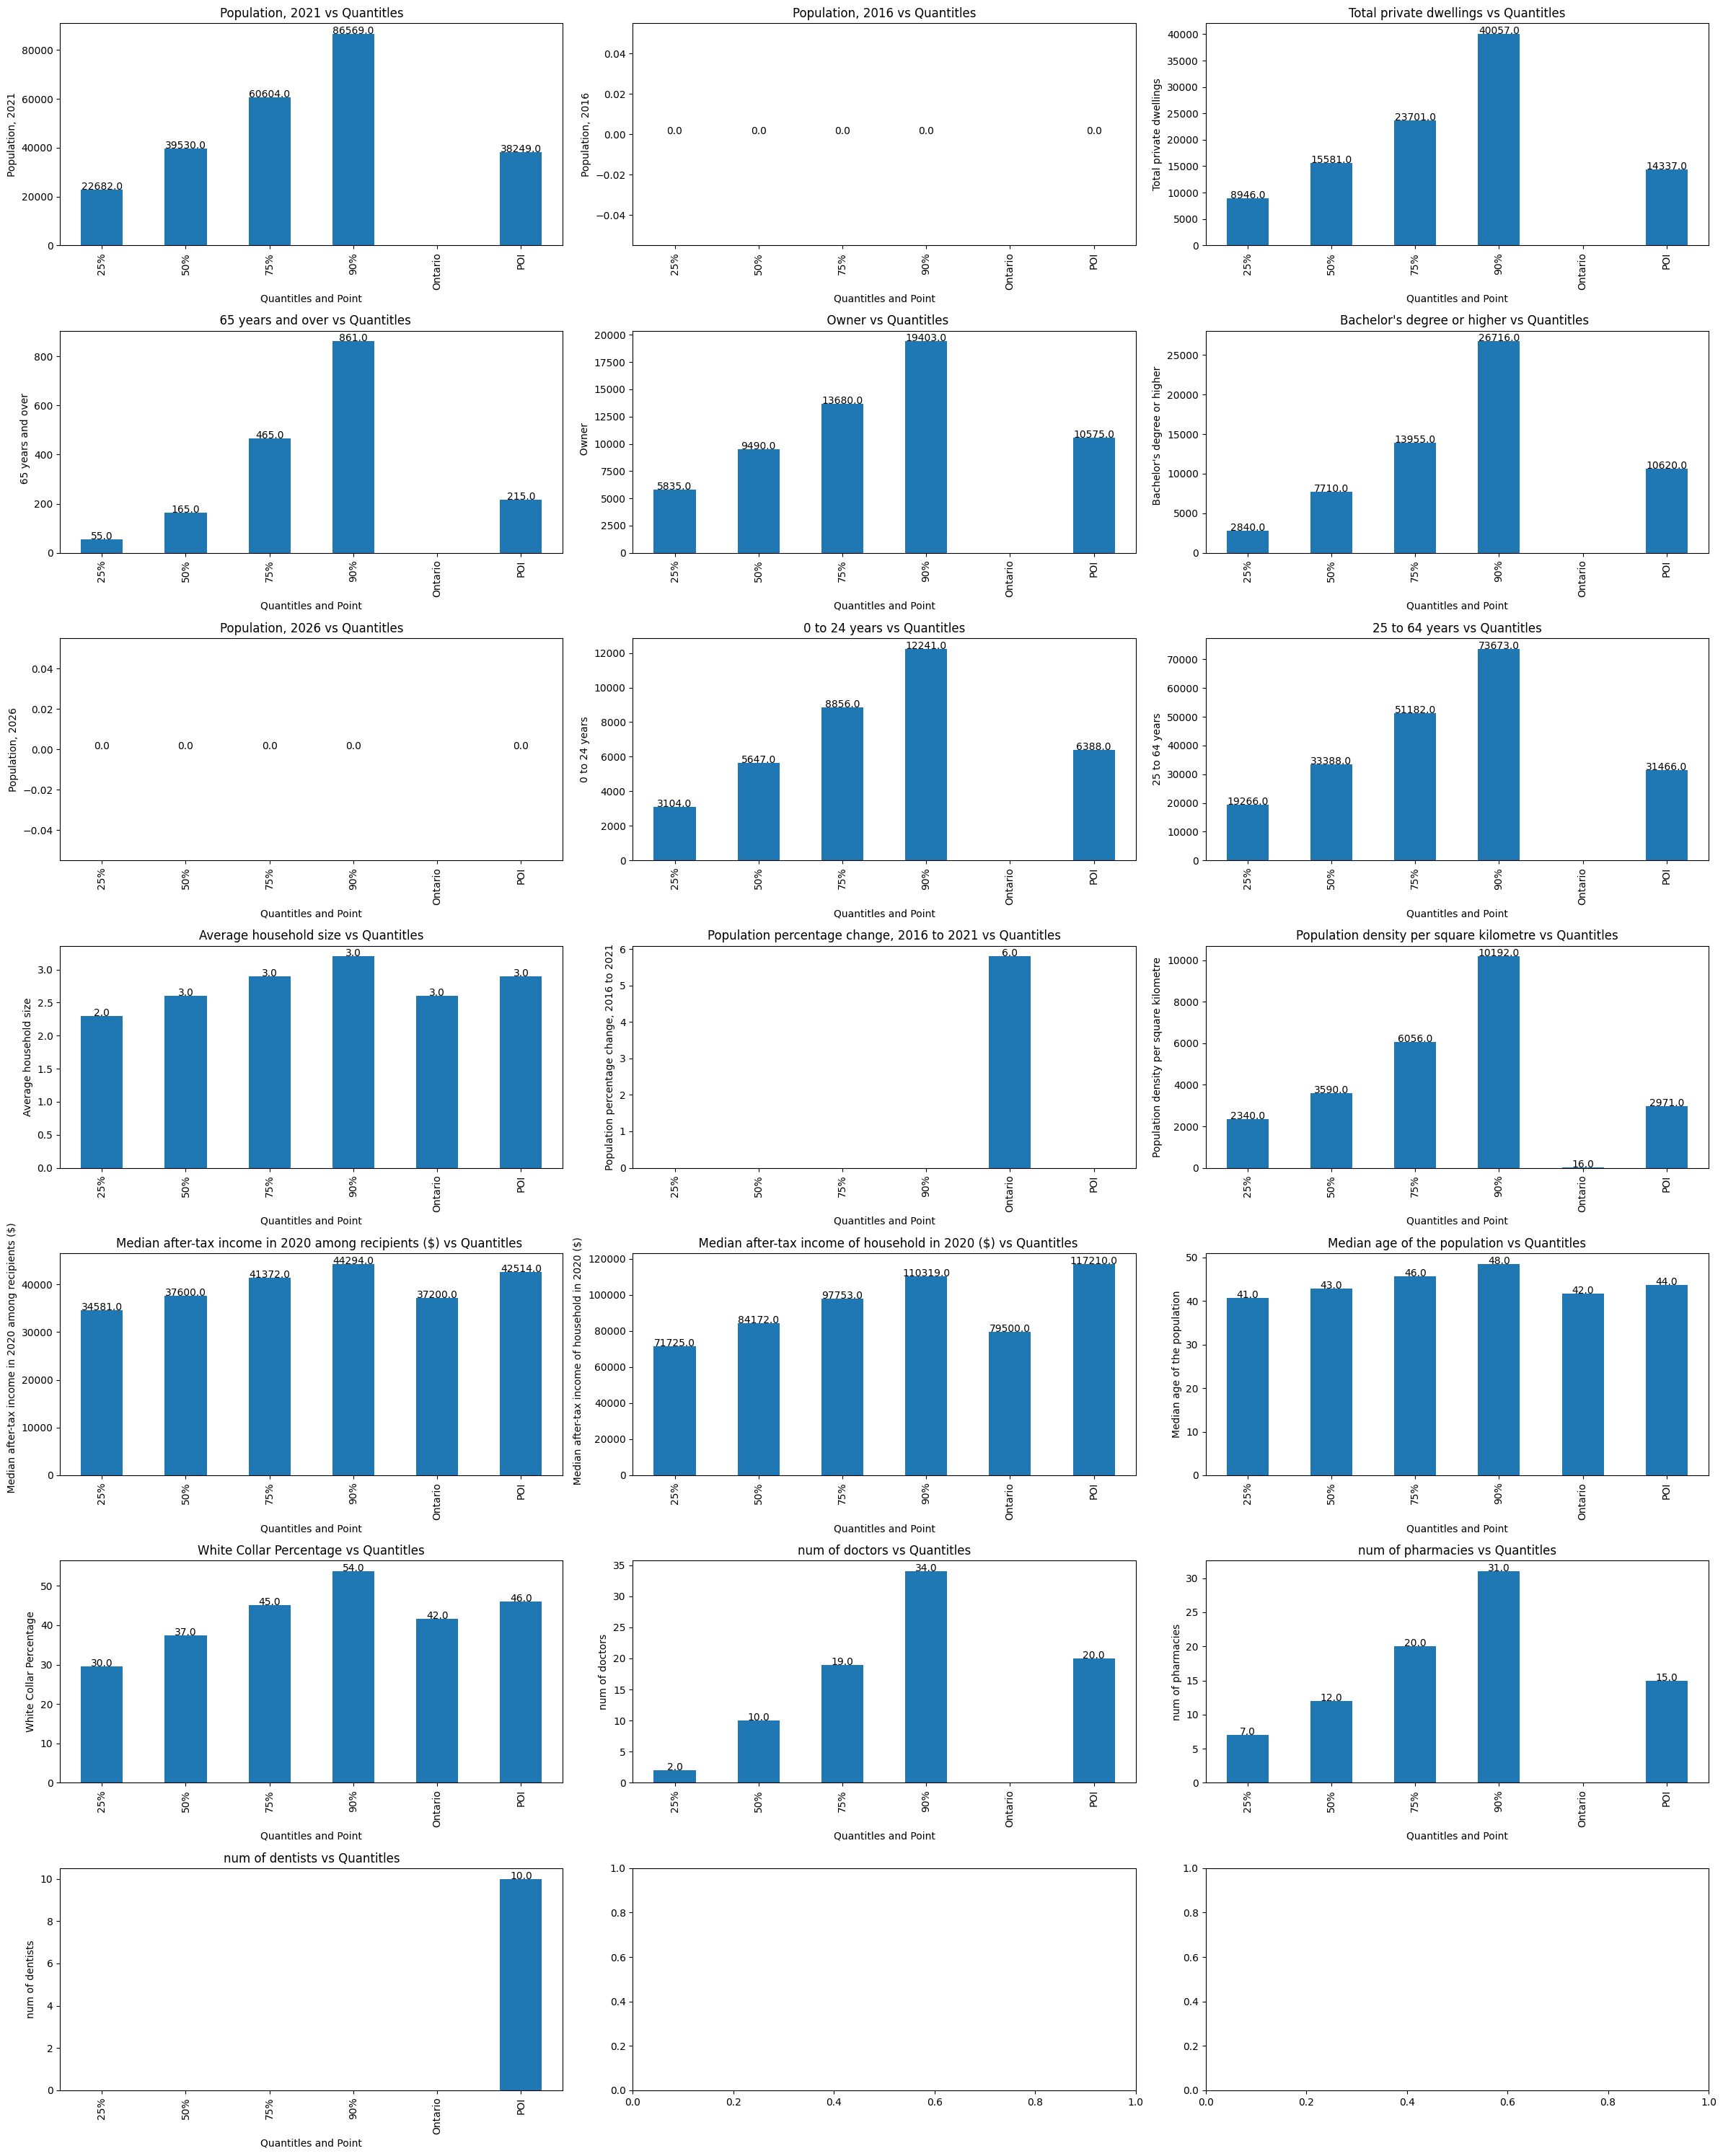

In [ ]:
quantitle_stats = pd.read_csv("quantitle_stats.csv")
combined_df = pd.concat([quantitle_stats, ontario_stats[mean_col], summary_stats_within_radius], axis=0, ignore_index=True)

fig, axs = plt.subplots(7,3,figsize=(24,30))
flat_axs = axs.flatten()
for idx, col in enumerate(sum_col + mean_col + ['num of doctors', 'num of pharmacies', 'num of dentists']):
    combined_df[col].plot(kind="bar", ax=flat_axs[idx])
    x_labels = ['25%', '50%', '75%', '90%', 'Ontario', 'POI']
    flat_axs[idx].title.set_text(f"{col} vs Quantitles")
    flat_axs[idx].set_xticklabels(x_labels)
    flat_axs[idx].set_xlabel("Quantitles and Point")
    flat_axs[idx].set_ylabel(col)

    for i, v in enumerate(combined_df[col]):
        flat_axs[idx].text(i, v, str(round(v,0)), ha='center')


plt.tight_layout()
plt.show()


In [ ]:
summary_stats_within_radius.to_csv("summary_stats_within_radius.csv")

7